# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 4 — Gaussians

---

Submission by:

* Batuhan, Oezcoemlekci, Matrikelnummer: 6300476

* Aakarsh, Nair, Matrikelnummer: 6546577

In [1]:
import jax.numpy as jnp
import logging

from jax import random
key = random.PRNGKey(0)
#from exponential_families import *
from tueplots import bundles
from matplotlib import pyplot as plt
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Exercise 4.2 (Coding Exercise)

> This week's Exercise is directly taken from Exercise 24.3. of [David JC MacKay](https://en.wikipedia.org/wiki/David_J._C._MacKay)'s [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/). (But don't waste your time trying to find an answer there :)

The terribly important quantity $\mu$ has been experimentally measured by seven scientists (A, B, C, D, E, F, G) with wildly differing experimental skills. They have reported the following measurements:

In [2]:
# We assume the same latent quantity $\mu$ for all observations.
X = jnp.array([-27.020,3.570,8.191,9.898,9.603,9.945,10.056])

Text(0.5, 0, 'measured value of $x$')

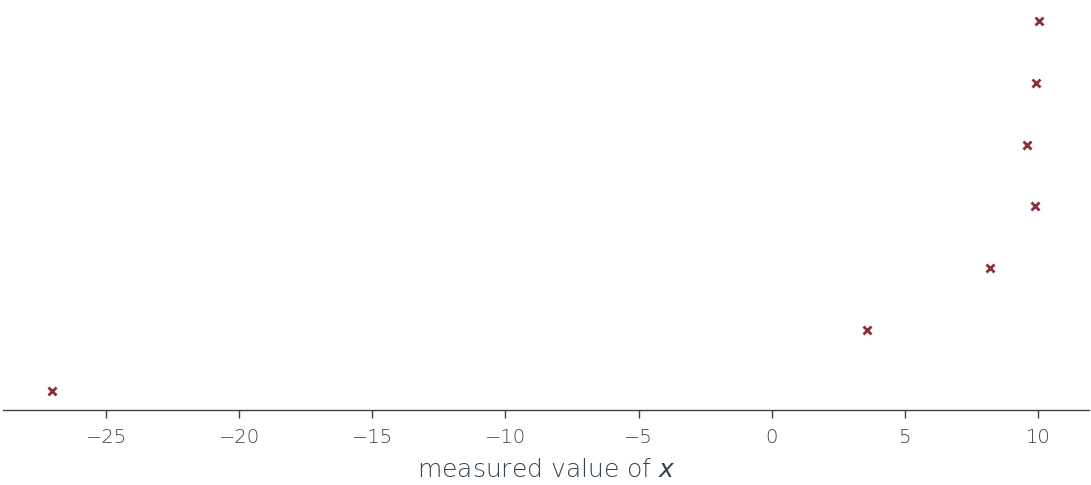

In [3]:
fig,ax = plt.subplots(1,1)
#ax.plot(X,random.uniform(key, shape=(7,)),'x',ms=3)
ax.plot(X,range(1,8),'x',ms=3)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('measured value of $x$')

We assume that they have all, independently of each other, made an unbiased Gaussian measurement of $\mu$: 
$$p(\boldsymbol{x}\mid \mu,\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{N}(x_i;\mu,\sigma_i ^2).$$ 
But we have to assume that their measurement errors $\sigma_i$ vary a lot (some are skilled experimentalists, others are unqualified). 

#### Task A: 
Implement the likelihood above as a single jax function (this is unfortunately a case where our neat `ExponentialFamily` base class is more awkward than useful). Try using a numerical optimizer to find *maximum likelihood estimators*, i.e. points $(\mu, \vec{\sigma})$ that maximize this function. Alternatively, you can try and identify such points directly by inspecting the likelihood by hand.
  
You probably agree that, intuitively, it looks pretty certain that A and B are both inept measurers, that D–G are better, and that the true value of $\mu$ is somewhere close to $10$. Are your findings consistent with this intuition?  

In [4]:
import jax
import jax.numpy as jnp
import jax.scipy.optimize as optimize

# Step 1: Define log-likelihood function
def log_likelihood(params, data):
    mean = params[0]
    vars = params[1:]
    log_probs = [0  for _ in range(data.shape[0])]
    for i in range(data.shape[0]):
        log_probs[i] = jax.scipy.stats.norm.logpdf(data[i], loc=mean, scale=vars[i])
    return -jnp.sum(jnp.array(log_probs))

def log_likelihood_alt(params, data):
    mean = params[0]
    vars = params[1:]
    log_probs = [0  for _ in range(data.shape[0])]
    for i in range(data.shape[0]):
        log_probs[i] = jnp.log(1/(jnp.sqrt(2*jnp.pi*vars[i]))) - (data[i]-mean)**2/(2*vars[i])
    return -jnp.sum(jnp.array(log_probs))

def log_likelihood_alt2(params, data):
    mean = params[0]
    vars = params[1:]
    log_probs = jnp.log(1/(jnp.sqrt(2*jnp.pi)*vars)) - (data-mean)**2/(2*vars)
    return -jnp.sum(log_probs)

#initial_params = jnp.array([10.0, 10.0-X[0], 10-X[1], 10-X[2], 10-X[3], 10-X[4], 10-X[5], 10-X[6]])  # Initial guess for mean and standard deviation
initial_params = jnp.array([10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0])  # Initial guess for mean and standard deviation

# Minimize the negative log-likelihood
result = optimize.minimize(log_likelihood, initial_params, args=(X,), method='BFGS')
estimated_params = result.x

print("Estimated Mean:", estimated_params[0])
print("Estimated Standart Deviations:",jnp.sqrt(estimated_params[1:8]))


Estimated Mean: 8.281892
Estimated Standart Deviations: [6.670353  1.2636932 0.5205992 1.1591171 1.0567701 1.1756024 1.2146856]


In [5]:
print('Sample mean:', jnp.mean(X))

Sample mean: 3.4632857


MLE minimizer does not yield intuitive results because of the first two data points A and B

Or alternatively the impact of A and B and their variances to mean can also be realized by: 

$$
L \equiv \log p\left(x \mid \bf{\sigma}, \mu\right)=-\sum_i \log \sigma_i-\sum_i \frac{\left(x_i-\mu\right)^2}{2 \sigma_i^2} \\
\frac{\partial L}{\partial \mu}=\sum_i\left(\frac{x_i-\mu}{\sigma_i^2}\right)=\sum_i \frac{x_i}{\sigma_i^2}-\mu \sum_i \frac{1}{\sigma_i^2}=0 \\
\mu=\frac{\sum_i \frac{x_i}{\sigma_i^2}}{\sum_i\frac{1}{\sigma_i^2}}
$$

#### Task B:
We will now instead provide a Bayesian answer. Let the prior on each $\sigma_i^{-2}$ be a broad [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), i.e. the distribution
$$ \mathcal{G}(z;\alpha,\beta)=\frac{\beta^\alpha}{\Gamma(\alpha)} z^{\alpha-1} e^{-\beta z},$$
and
$$p(\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{G}(\sigma_i^{-2};\alpha,\beta),$$ 
with, say, $\alpha=1$, $\beta=0.1$. 

Let the prior for $\mu$ be a broad Gaussian $p(\mu) = \mathcal{N}(\mu; m, v^2)$ with mean $m = 0$ and standard deviation $v = 10^3$. 

Find the posterior for $\mu$. Plot this posterior for $\mu$, both for the data given above and for $\boldsymbol{x} = \{13.01, 7.39\}$.


**Hint:** First, remember that the Gamma is the conjugate prior for the Gaussian with fixed mean $\mu$. The marginal $p(\boldsymbol{x}\mid\mu)$ can thus be computed using the `log_marginal_pdf` function you implemented generically for exponential families last week, and which has an analytic form. Then use Bayes' theorem a second time to find $p(\mu\mid\boldsymbol{x})$ up to normalization, by directly multiplying the prior for $\mu$ and the marginal likelihood terms you just found. 


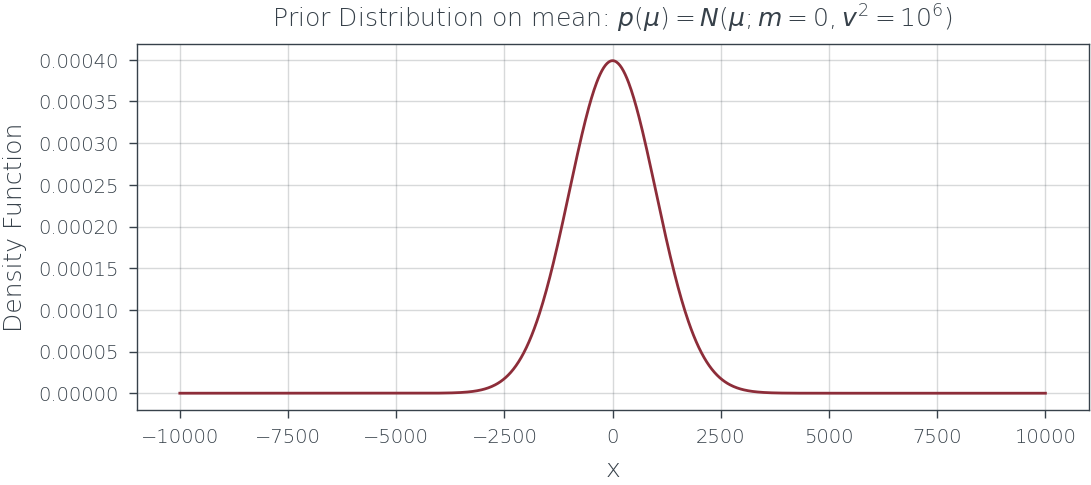

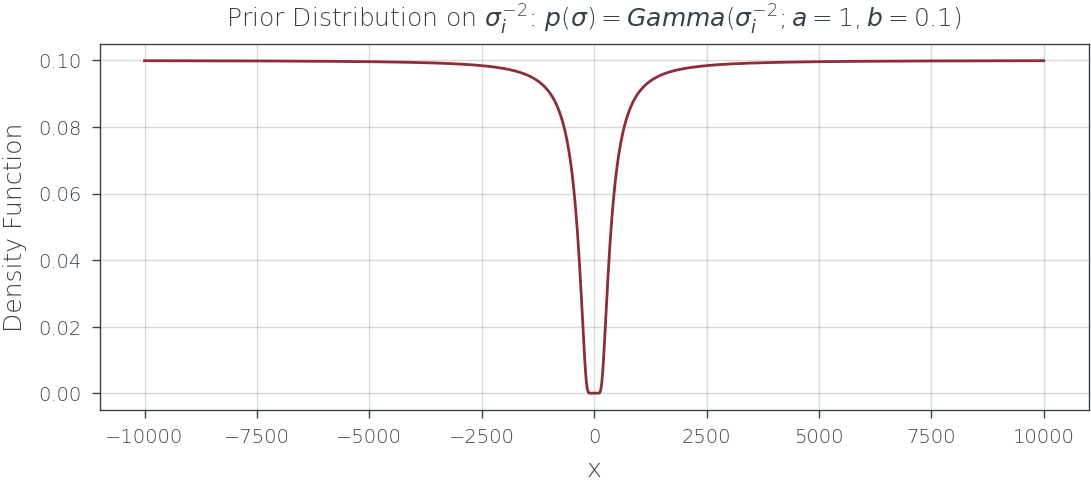

In [6]:
# Define the parameters of the normal distribution
m = 0.0  # Mean
v = 10**3.0  # Standard deviation

# Define the parameters of the gamma distribution
alpha = 1.0
beta = 0.1  

# Data
X_1 = X
X_2 = jnp.array([13.01, 7.39])

def plot(x, pdf, title):
    #plt.figure(figsize=(10, 5))
    plt.plot(x, pdf)
    plt.xlabel('x')
    plt.ylabel('Density Function')
    plt.title(f'{title}')
    plt.grid(True)
    plt.show()

def Gamma_dist(x, alpha, beta):
    return (beta**alpha)/jax.scipy.special.gamma(alpha)*x**(alpha-1)*jnp.exp(-beta*x)

def gaussian_on_mu(mu, m, v):
    # v is std
    return jax.scipy.stats.norm.pdf(mu, loc=m, scale=v)

def gamma_on_sigma(sigma, alpha, beta, use_jax=True):
    if use_jax:
        return jax.scipy.stats.gamma.pdf(1/(sigma**2), a=alpha, scale=1/beta)
    return Gamma_dist(1/(sigma**2), alpha, beta)

# Create a range of x values.
x = jnp.linspace(m-10000, m+10000, 1000)

pdf_prior_mu = gaussian_on_mu(x, m, v)
plot(x, pdf_prior_mu, 'Prior Distribution on mean: $p(\mu)= N(\mu; m=0, v^2=10^6)$')

sigma = jnp.linspace(-10, 10, 1000)

pdf_prior_sigma = gamma_on_sigma(sigma, alpha, beta)
plot(x, pdf_prior_sigma, 'Prior Distribution on $\sigma_i^{-2}$: $p(\sigma)= Gamma(\sigma_i^{-2}; a=1, b=0.1)$')


Bayesian for the posterior probability of $\sigma$:
$$
P\left(\sigma \mid x, \mu\right)=\frac{P\left(x \mid \sigma, \mu\right) P\left(\sigma\right)}{P\left(x \mid \mu\right)}
$$
where
$$
P\left(x \mid \sigma, \mu\right)=\left(\frac{1}{2 \pi}\right)^{N / 2}\left(\Pi_n \frac{1}{\sigma_n}\right) \exp \left(-\sum_n \frac{\left(x_n-\mu\right)^2}{2 \sigma_n^2}\right)
$$
$$
P\left(\sigma\right)=\left(\frac{\beta^\alpha}{\Gamma(\alpha) }\right)^N \Pi_n\left(\sigma_n\right)^{\alpha-1} \exp \left(-\sum_n \beta \sigma_n\right)
$$
where $(\beta, \alpha)=(0.1,1)$

And the normalizing constant is
$$
P\left(x \mid \mu\right)=\int_0^{\infty} P\left(x \mid \sigma, \mu\right) \Pi_n  P\left(\sigma_n \right) d \sigma
$$

The posterior probability of $\mu$:
$$
P\left(\mu \mid x\right)=\frac{P\left(x \mid \mu\right) P(\mu)}{P\left(x\right)}
$$
and the prior is determined by
$P(\mu) = \mathcal{N}(\mu; m, v^2)$ and the normalizing constant is
$$
P\left(x\right)=\int_{-\infty}^{\infty} d \mu P\left(x\mid \mu\right) P(\mu)
$$

Note that, during coding, integrals will be converted into summations for the sake of discreteness.

### Strategy

+ First using the first Bayesian equation, obtain $P(x|\mu)$ which is the normalization term. 

+ Then using the second Bayesian, obtain $P(\mu|x)$

Text(0.5, 1.0, 'Posterior Distribution on mean: $p(\\mu|x)$')

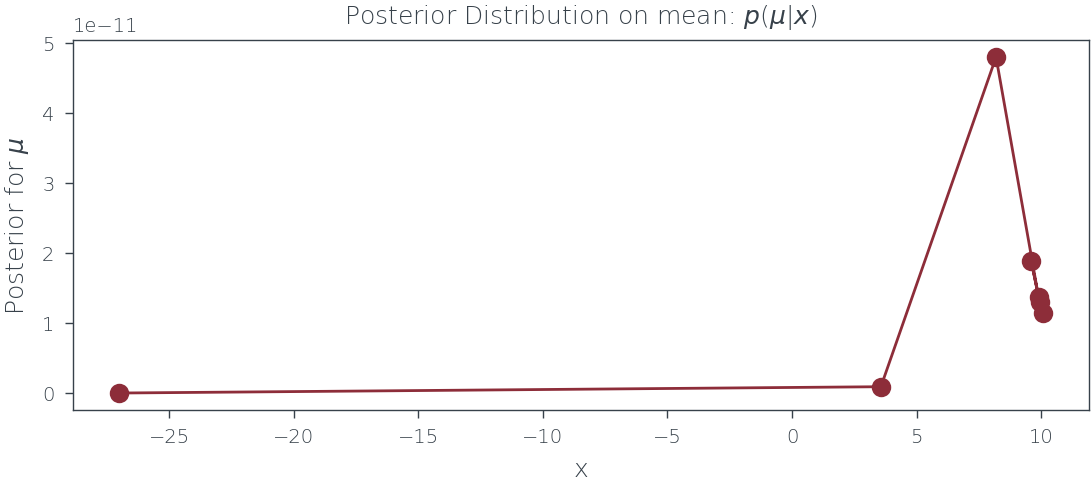

In [7]:
X = jnp.array(X_1)

result = optimize.minimize(log_likelihood, initial_params, args=(X,), method='BFGS')
estimated_params = result.x

mean = estimated_params[0]
std_deviations = jnp.sqrt(estimated_params[1:X.shape[0]+1])

#print('Mean: ', mean)
#print('Stds: ', std_deviations)

def p_x_given_mu_sigma_single(x, mean, std_deviation):
    return jax.scipy.stats.norm.pdf(x, loc=mean, scale=std_deviation)

def p_x_given_mu_sigma(x, mean, std_deviations):
    #use likelihood estimates
    log_product = 0
    for i in range(x.shape[0]):
        log_product += jnp.log(p_x_given_mu_sigma_single(x[i], mean, std_deviations[i]))
    return jnp.exp(log_product)
    

def p_sigma(std_deviations, alpha, beta):
    prob = 0
    for i in range(std_deviations.shape[0]):
        prob += jnp.log(gamma_on_sigma(std_deviations[i], alpha, beta))
    return jnp.exp(prob)

#def p_sigma_given_x_mu(std_deviations, alpha, beta, x, mean):
#    log_product = 0
#    for i in range(std_deviations.shape[0]):
#        log_product += jnp.log(p_x_given_mu_sigma(x[i], mean, std_deviations[i])) + jnp.log(gamma_on_sigma(std_deviations[i], alpha, beta)) 


def p_x_given_mu(x, mean, std_deviations, alpha=1, beta=0.1):
    normalization = jnp.zeros(x.shape[0])
    prior_sigma = p_sigma(std_deviations, alpha, beta)
    for i in range(x.shape[0]):
        normalization += p_x_given_mu_sigma_single(x, mean, std_deviations[i]) * prior_sigma
    return normalization

#def p_x(x):
#    return jnp.ones(x.shape[0]) / x.shape[0]

def p_mu_given_x(x, mean, std_deviations, m=0, v=10**3):
    dist = p_x_given_mu(x, mean, std_deviations) * gaussian_on_mu(mean, m, v)
    return dist

posterior = p_mu_given_x(X, mean, std_deviations)
#print('Posterior means given x:', posterior)
# Plot posterior
plt.plot(X, posterior, marker="o")
plt.xlabel('x')
plt.ylabel('Posterior for $\mu$')
plt.title('Posterior Distribution on mean: $p(\mu|x)$')

Text(0.5, 1.0, 'Posterior Distribution on mean: $p(\\mu|x)$')

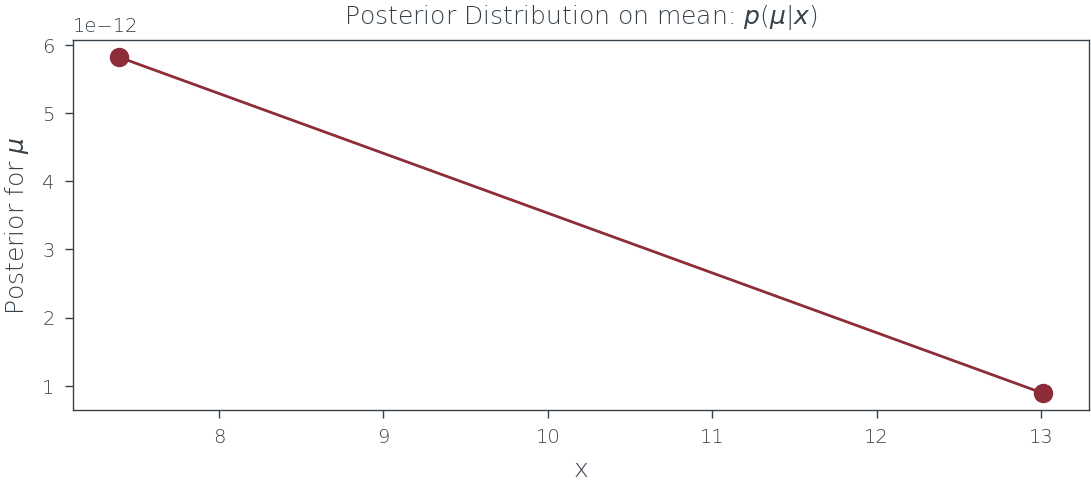

In [8]:
X = jnp.array(X_2)
result = optimize.minimize(log_likelihood, initial_params, args=(X,), method='BFGS')
estimated_params = result.x

posterior = p_mu_given_x(X, mean, std_deviations)
#print('Posterior means given x:', posterior)
# Plot posterior
plt.plot(X, posterior, marker="o")
plt.xlabel('x')
plt.ylabel('Posterior for $\mu$')
plt.title('Posterior Distribution on mean: $p(\mu|x)$')